# Test and visualize the driving scenarios

In [1]:
using POMDPs, StatsBase, POMDPToolbox, DeepRL, Parameters, GridInterpolations
using AutomotiveDrivingModels, AutoUrban, AutoViz
using Reel 

In [2]:
rng = MersenneTwister(1);

 overwritten in module Logging at C:\Users\Maxime\.julia\v0.6\Logging\src\Logging.jl:115.

In [3]:
include("constants.jl")
include("utils/helpers.jl")
include("utils/occlusions.jl")
include("utils/rendering.jl")

 overwritten in module Logging at C:\Users\Maxime\.julia\v0.6\Logging\src\Logging.jl:115.

animate_record (generic function with 1 method)

Float64, 1

In [4]:
include("envs/occluded_crosswalk_env.jl")
include("envs/multi_lane_T_env.jl")
include("envs/rendering.jl")

}, AutomotiveDrivingModels.LatLonAccel) in module AutomotiveDrivingModels at C:\Users\Maxime\.julia\v0.6\AutomotiveDrivingModels\src\2d\actions\lat_lon_accel.jl:13 overwritten in module AutoUrban at C:\Users\Maxime\.julia\v0.6\AutoUrban\src\simulation\actions.jl:10.


In [5]:
include("driver_models/route_following_idm.jl")
include("driver_models/stop.jl")
include("driver_models/intersection_driver.jl")
include("driver_models/constant_pedestrian.jl")
include("driver_models/crosswalk_driver.jl")

dist_to_stop (generic function with 1 method)

## Scenario 1: Single agent occluded crosswalk

Discrete environment, provides explicit transition and observation probability distributions. Support only one pedestrian

In [6]:
# include("single_crosswalk/occluded_crosswalk_env.jl")
include("single_crosswalk/pomdp_types.jl")
include("single_crosswalk/spaces.jl")
include("single_crosswalk/transition.jl")
include("single_crosswalk/observation.jl")
include("single_crosswalk/belief.jl")
include("single_crosswalk/adm_helpers.jl")
include("single_crosswalk/render_helpers.jl")

animate_hist (generic function with 1 method)

In [18]:
pomdp = SingleOCPOMDP()

SingleOCPOMDP(CrosswalkEnv(Roadway, AutomotiveDrivingModels.Lane(LaneTag(2, 1), AutomotiveDrivingModels.CurvePt[CurvePt({25.000, -10.000, 1.571}, 0.000, 0.000, NaN), CurvePt({25.000, 10.000, 1.571}, 20.000, 0.000, NaN)], 6.0, AutomotiveDrivingModels.SpeedLimit(-Inf, Inf), AutomotiveDrivingModels.LaneBoundary(:unknown, :unknown), AutomotiveDrivingModels.LaneBoundary(:unknown, :unknown), AutomotiveDrivingModels.LaneConnection[], AutomotiveDrivingModels.LaneConnection[]), AutomotiveDrivingModels.ConvexPolygon[ConvexPolygon: len 4 (max 4 pts)
	VecE2(15.000, -1.500)
	VecE2(15.000, -4.500)
	VecE2(21.500, -4.500)
	VecE2(21.500, -1.500)
], CrosswalkParams(2, 50.0, 3.0, 20.0, 6.0, 5.0, 37.0, 8.0, 100, 0.5, 2.0, 10.0)), VehicleDef(CAR, 4.000, 1.800), VehicleDef(PEDESTRIAN, 1.000, 1.000), 2.0, 1.0, 1.0, 5.0, -5.0, 37.0, 5.0, 0.5, 0.3, 0.3, false, 1.0, 1.0, 1.0, -1.0, 0.0, 1.0, 0.95)

In [19]:
policy = solve(RandomSolver(rng), pomdp)
up = updater(policy);

**Simulate**

In [20]:
hr = HistoryRecorder(rng=rng)
@time hist = simulate(hr, pomdp, policy, up);

  0.017894 seconds (25.88 k allocations: 1.780 MiB)


**Rendering**

In [21]:
duration, fps, render_hist = animate_hist(pomdp, hist)
film = roll(render_hist, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("C:\\Users\\Maxime\\AppData\\Local\\Temp\\jl_BD11.tmp", 0x000000000000002e, 2.0, nothing)

## Scenario 2: Multi-agent Crosswalk 

Generative model for the occluded crosswalk scenario, support multiple pedestrians, continuous space

In [45]:
# include("multi_crosswalk/occluded_crosswalk_env.jl")
include("multi_crosswalk/pomdp_types.jl")
include("multi_crosswalk/generative_model.jl")
include("multi_crosswalk/render_helpers.jl")

13-Feb 19:20:56:WARNING:root:replacing docs for 'initial_ego :: Tuple{OCPOMDP,AbstractRNG}' in module 'Main'.
13-Feb 19:20:56:WARNING:root:replacing docs for 'initial_pedestrian :: Union{Tuple{OCPOMDP,Records.Frame{Records.Entity{AutomotiveDrivingModels.VehicleState,AutomotiveDrivingModels.VehicleDef,Int64}},AbstractRNG,Bool}, Tuple{OCPOMDP,Records.Frame{Records.Entity{AutomotiveDrivingModels.VehicleState,AutomotiveDrivingModels.VehicleDef,Int64}},AbstractRNG}}' in module 'Main'.
13-Feb 19:20:56:WARNING:root:replacing docs for 'get_off_the_grid :: Tuple{OCPOMDP}' in module 'Main'.


In [69]:
pomdp = OCPOMDP(ΔT=0.5, p_birth=0.2, max_ped=1);
overlay = LidarOverlay(pomdp.sensor);

In [70]:
policy = solve(RandomSolver(rng), pomdp)
up = updater(policy);

In [62]:
hr = HistoryRecorder(rng=rng, max_steps=100)
@time hist = simulate(hr, pomdp, policy, up);

  0.001111 seconds (3.96 k allocations: 678.398 KiB)


In [49]:
duration, fps, render_hist = animate_hist(pomdp, hist, SceneOverlay[overlay])
film = roll(render_hist, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("C:\\Users\\Maxime\\AppData\\Local\\Temp\\jl_3314.tmp", 0x000000000000002f, 10.0, nothing)

In [50]:
scene = Scene()
models = Dict{Int, DriverModel}()
for i=1:5
    ped = initial_pedestrian(pomdp, scene, rng, true)
    push!(scene, ped)
    models[ped.id] = ConstantPedestrian()
end
car = initial_ego(pomdp, rng)
push!(scene, car)

timestep = 0.1


models[1] = CrosswalkDriver(crosswalk = pomdp.env.crosswalk,
                            intersect = get_lane(pomdp.env.roadway, car))


nticks = 200
rec = SceneRecord(nticks+1, timestep)
@time simulate!(rec, scene, pomdp.env.roadway, models, nticks)

buffer ped ttc 4.5
ego ttc 3.1814692584352207
has_crossed ttc-1.5
min ped ttc 1.5297421418296164
braking! d = 15.0
veh 1 go false stop false clear false
buffer ped ttc 4.5
ego ttc 3.3287143560741335
has_crossed ttc-1.5
min ped ttc 0.7170756302676002
braking! d = 14.2429509088349
veh 1 go false stop false clear false
buffer ped ttc 4.5
ego ttc 3.451004993663879
has_crossed ttc-1.5
min ped ttc 1.1106566046012771
braking! d = 13.53777422617068
veh 1 go false stop false clear false
buffer ped ttc 4.5
ego ttc 3.55585943039195
has_crossed ttc-1.5
min ped ttc 0.6170756302676015
braking! d = 12.87509290185241
veh 1 go false stop false clear false
buffer ped ttc 4.5
ego ttc 3.648214079923812
has_crossed ttc-1.5
min ped ttc 0.5170756302676018
braking! d = 12.248516009133812
veh 1 go false stop false clear false
buffer ped ttc 4.5
ego ttc 3.731596335683055
has_crossed ttc-1.5
min ped ttc 0.9606566046012768
braking! d = 11.65345598655158
veh 1 go false stop false clear false
buffer ped ttc 4.5
ego

veh 1 go false stop false clear false
buffer ped ttc 4.5
ego ttc 47.05234922568725
has_crossed ttc-1.5
min ped ttc 4.5
braking! d = 0.32992435547480525
veh 1 go false stop false clear false
buffer ped ttc 4.5
ego ttc 50.179828966987245
has_crossed ttc-1.5
min ped ttc -1.0203406811891327
braking! d = 0.30867556816799535
veh 1 go false stop false clear false
buffer ped ttc 4.5
ego ttc 53.52344522818597
has_crossed ttc-1.5
min ped ttc 0.9004606728057638
braking! d = 0.28879235393772973
veh 1 go false stop false clear false
buffer ped ttc 4.5
ego ttc 57.09807260641249
has_crossed ttc-1.5
min ped ttc 0.8004606728057642
braking! d = 0.27018740975052324
veh 1 go false stop false clear false
buffer ped ttc 4.5
ego ttc 60.91961385202448
has_crossed ttc-1.5
min ped ttc -1.220340681189131
braking! d = 0.25277894081800767
veh 1 go false stop false clear false
buffer ped ttc 4.5
ego ttc 65.00507059159825
has_crossed ttc-1.5
min ped ttc 4.5
braking! d = 0.23649032519591984
veh 1 go false stop false 

SceneRecord(nscenes=201)

In [51]:
cam = FitToContentCamera(0.)
duration, fps, render_rec = animate_record(pomdp.env, rec, sim_dt=timestep)
film = roll(render_rec, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("C:\\Users\\Maxime\\AppData\\Local\\Temp\\jl_C82.tmp", 0x00000000000000c9, 10.0, nothing)

## Scenario 3 : Single agent intersection

Explicit formulation with transition and observation probability distribution. Only support one vehicle

In [18]:
include("single_intersection/occluded_intersection_env.jl")
include("single_intersection/pomdp_types.jl")
include("single_intersection/spaces.jl")
include("single_intersection/transition.jl")
include("single_intersection/observation.jl")
include("single_intersection/belief.jl")
include("single_intersection/render_helpers.jl")

animate_hist (generic function with 3 methods)

In [19]:
pomdp = SingleOIPOMDP();

In [20]:
policy = solve(RandomSolver(rng), pomdp)
up = updater(policy);

In [21]:
hr = HistoryRecorder(rng=rng, max_steps=100)
hist = simulate(hr, pomdp, policy, up);

In [22]:
duration, fps, render_hist = animate_hist(pomdp, hist)
film = roll(render_hist, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("C:\\Users\\Maxime\\AppData\\Local\\Temp\\jl_FC43.tmp", 0x000000000000000c, 2.0, nothing)

## Scenario 4 - Multi Lane Multi agent intersection

In [22]:
# include("multi_lane_T_intersection/multi_lane_T_env.jl")
include("multi_lane_T_intersection/pomdp_types.jl")
include("multi_lane_T_intersection/generative_model.jl")
include("multi_lane_T_intersection/render_helpers.jl")

In [23]:
include("driver_models/intersection_driver.jl")

13-Feb 12:45:00:WARNING:root:replacing docs for 'grow_wait_list! :: Tuple{IntersectionDriver,Records.Frame{Records.Entity{AutomotiveDrivingModels.VehicleState,AutomotiveDrivingModels.VehicleDef,Int64}},AutomotiveDrivingModels.Roadway,Int64}' in module 'Main'.
13-Feb 12:45:00:WARNING:root:replacing docs for 'ungrow_wait_list! :: Tuple{IntersectionDriver,Records.Frame{Records.Entity{AutomotiveDrivingModels.VehicleState,AutomotiveDrivingModels.VehicleDef,Int64}},AutomotiveDrivingModels.Roadway,Int64}' in module 'Main'.
13-Feb 12:45:00:WARNING:root:replacing docs for 'tts :: Tuple{Float64,Float64}' in module 'Main'.
13-Feb 12:45:00:WARNING:root:replacing docs for 'is_at_intersection :: Tuple{IntersectionDriver,Records.Entity{AutomotiveDrivingModels.VehicleState,AutomotiveDrivingModels.VehicleDef,Int64},AutomotiveDrivingModels.Roadway}' in module 'Main'.
13-Feb 12:45:00:WARNING:root:replacing docs for 'update_priority! :: Tuple{IntersectionDriver,Records.Frame{Records.Entity{AutomotiveDrivi

get_dist_to_end

In [24]:
env = IntersectionEnv(TInterParams(nlanes_main = 1))
pomdp = OIPOMDP(env=env, ΔT=0.5, max_cars=10);

In [25]:
policy = solve(RandomSolver(rng), pomdp)
up = updater(policy);

mutable struct AccelPolicy <: Policy
    problem::OIPOMDP
end
policy = AccelPolicy(pomdp)
function POMDPs.action(policy::AccelPolicy, b::Void)
    return actions(policy.problem)[2]
end

In [26]:
hr = HistoryRecorder(rng=rng, max_steps=100)
@time hist = simulate(hr, pomdp, policy, up);

  0.813984 seconds (258.71 k allocations: 15.411 MiB, 1.11% gc time)


In [27]:
duration, fps, render_hist = animate_hist(pomdp, hist, [IDOverlay()])
film = roll(render_hist, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("C:\\Users\\Maxime\\AppData\\Local\\Temp\\jl_37A2.tmp", 0x0000000000000064, 2.0, nothing)

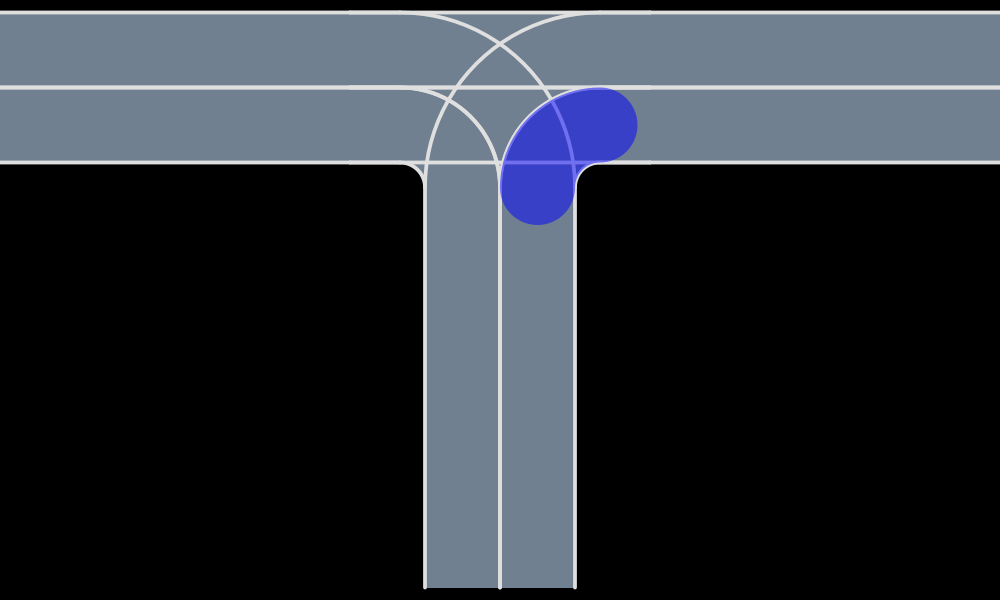

In [29]:
using Interact

scene = Scene()

type LaneOverlay <: SceneOverlay
    lane::Lane
    color::Colorant
end
function AutoViz.render!(rendermodel::RenderModel, overlay::LaneOverlay, scene::Scene, roadway::Roadway)
    render!(rendermodel, overlay.lane, roadway, color_asphalt=overlay.color)
    return rendermodel
end

# @manipulate for i in 1 : length(env.roadway.segments)
#     AutoViz.render(scene, env.roadway, [LaneOverlay(env.roadway[LaneTag(i,1)], RGBA(0.0,0.0,1.0,0.5))], cam=FitToContentCamera(0.))
# end

i=15
AutoViz.render(scene, env.roadway, [LaneOverlay(env.roadway[LaneTag(i,1)], RGBA(0.0,0.0,1.0,0.5))], cam=FitToContentCamera(0.))

In [30]:
include("driver_models/intersection_driver.jl")

13-Feb 09:32:27:WARNING:root:replacing docs for 'grow_wait_list! :: Tuple{IntersectionDriver,Records.Frame{Records.Entity{AutomotiveDrivingModels.VehicleState,AutomotiveDrivingModels.VehicleDef,Int64}},AutomotiveDrivingModels.Roadway,Int64}' in module 'Main'.
13-Feb 09:32:27:WARNING:root:replacing docs for 'ungrow_wait_list! :: Tuple{IntersectionDriver,Records.Frame{Records.Entity{AutomotiveDrivingModels.VehicleState,AutomotiveDrivingModels.VehicleDef,Int64}},AutomotiveDrivingModels.Roadway,Int64}' in module 'Main'.
13-Feb 09:32:27:WARNING:root:replacing docs for 'tts :: Tuple{Float64,Float64}' in module 'Main'.
13-Feb 09:32:27:WARNING:root:replacing docs for 'is_at_intersection :: Tuple{IntersectionDriver,Records.Entity{AutomotiveDrivingModels.VehicleState,AutomotiveDrivingModels.VehicleDef,Int64},AutomotiveDrivingModels.Roadway}' in module 'Main'.
13-Feb 09:32:27:WARNING:root:replacing docs for 'update_priority! :: Tuple{IntersectionDriver,Records.Frame{Records.Entity{AutomotiveDrivi

get_dist_to_end

In [31]:
scene = Scene()
for i = 1:20
    veh = initial_car(pomdp, scene, rng, true)
    push!(scene, veh)
end
clean_scene!(pomdp.env, scene)

timestep = 0.1

models = Dict{Int, DriverModel}()
# constant speed model
for veh in scene
    route = random_route(rng, env.roadway, lane)
    intersection_entrances = get_start_lanes(env.roadway)
    intersection_exits = get_exit_lanes(intersection_entrances, env.roadway)
    models[veh.id] = IntersectionDriver(navigator=RouteFollowingIDM(route=route),
                                   intersection=Lane[route[1], route[2]], 
                                   intersection_entrances = intersection_entrances,
                                   intersection_exits = intersection_exits,
                                   stop_delta=0.,
                                   accel_tol=0.)
end
# models[0] = RouteFollowingIDM(route=route)

nticks = 100
rec = SceneRecord(nticks+1, timestep)
@time simulate!(rec, scene, env.roadway, models, nticks)

LoadError: [91mUndefVarError: lane not defined[39m

In [32]:
duration, fps, render_rec = animate_record(rec, env, sim_dt=timestep)
film = roll(render_rec, fps = fps, duration = duration)

LoadError: [91mMethodError: no method matching render(::Records.Frame{Records.Entity{AutomotiveDrivingModels.VehicleState,AutomotiveDrivingModels.VehicleDef,Int64}}, ::Array{AutoViz.SceneOverlay,1}, ::IntersectionEnv; cam=AutoViz.FitToContentCamera(0.0), car_colors=Dict{Int64,ColorTypes.Colorant}(Pair{Int64,ColorTypes.Colorant}(7, RGB{N0f8}(1.0,0.0,0.498)),Pair{Int64,ColorTypes.Colorant}(13, RGB{N0f8}(1.0,0.0,0.498)),Pair{Int64,ColorTypes.Colorant}(10, RGB{N0f8}(1.0,0.0,0.498)),Pair{Int64,ColorTypes.Colorant}(2, RGB{N0f8}(1.0,0.0,0.498)),Pair{Int64,ColorTypes.Colorant}(3, RGB{N0f8}(1.0,0.0,0.498)),Pair{Int64,ColorTypes.Colorant}(19, RGB{N0f8}(1.0,0.0,0.498)),Pair{Int64,ColorTypes.Colorant}(17, RGB{N0f8}(1.0,0.0,0.498)),Pair{Int64,ColorTypes.Colorant}(5, RGB{N0f8}(1.0,0.0,0.498)),Pair{Int64,ColorTypes.Colorant}(8, RGB{N0f8}(1.0,0.0,0.498))))[0m
Closest candidates are:
  render(::Records.Frame{Records.Entity{S,D,I}}, ::R; canvas_width, canvas_height, rendermodel, cam, car_colors) where {S, D, I, R} at C:\Users\Maxime\.julia\v0.6\AutoViz\src\interface.jl:60
  render(::Records.Frame{Records.Entity{S,D,I}}, ::R, [91m::AbstractArray{O<:AutoViz.SceneOverlay,1}[39m; canvas_width, canvas_height, rendermodel, cam, car_colors) where {S, D, I, O<:AutoViz.SceneOverlay, R} at C:\Users\Maxime\.julia\v0.6\AutoViz\src\overlays.jl:25
  render([91m::Cairo.CairoContext[39m, [91m::Records.Frame{Records.Entity{S,D,I}}[39m, ::R; rendermodel, cam, car_colors) where {S, D, I, R} at C:\Users\Maxime\.julia\v0.6\AutoViz\src\interface.jl:39
  ...[39m

In [33]:
intersection_entrances = get_start_lanes(env.roadway)
intersection_exits = get_exit_lanes(intersection_entrances, env.roadway)

6-element Array{AutomotiveDrivingModels.Lane,1}:
 AutomotiveDrivingModels.Lane(LaneTag(9, 1), AutomotiveDrivingModels.CurvePt[CurvePt({6.000, 1.500, 3.142}, 0.000, 0.000, 0.000), CurvePt({4.000, 1.500, 3.142}, 2.000, 0.000, 0.000)], 3.0, AutomotiveDrivingModels.SpeedLimit(-Inf, Inf), AutomotiveDrivingModels.LaneBoundary(:solid, :white), AutomotiveDrivingModels.LaneBoundary(:solid, :white), AutomotiveDrivingModels.LaneConnection[LaneConnection(D, CurveIndex(1, 1.000), RoadIndex({1, 0.000000}, {10, 1}), LaneConnection(D, CurveIndex(1, 1.000), RoadIndex({1, 0.000000}, {10, 1})], AutomotiveDrivingModels.LaneConnection[LaneConnection(U, CurveIndex(1, 0.000), RoadIndex({1, 1.000000}, {1, 1})])                                                                                                                                                                                                                                                                                                                

In [34]:
get_exit_lanes(intersection_entrances, env.roadway)

6-element Array{AutomotiveDrivingModels.Lane,1}:
 AutomotiveDrivingModels.Lane(LaneTag(9, 1), AutomotiveDrivingModels.CurvePt[CurvePt({6.000, 1.500, 3.142}, 0.000, 0.000, 0.000), CurvePt({4.000, 1.500, 3.142}, 2.000, 0.000, 0.000)], 3.0, AutomotiveDrivingModels.SpeedLimit(-Inf, Inf), AutomotiveDrivingModels.LaneBoundary(:solid, :white), AutomotiveDrivingModels.LaneBoundary(:solid, :white), AutomotiveDrivingModels.LaneConnection[LaneConnection(D, CurveIndex(1, 1.000), RoadIndex({1, 0.000000}, {10, 1}), LaneConnection(D, CurveIndex(1, 1.000), RoadIndex({1, 0.000000}, {10, 1})], AutomotiveDrivingModels.LaneConnection[LaneConnection(U, CurveIndex(1, 0.000), RoadIndex({1, 1.000000}, {1, 1})])                                                                                                                                                                                                                                                                                                                

In [35]:
for lane in get_start_lanes(env.roadway)
    println(lane.exits.target.tag)
end

LoadError: [91mtype Array has no field target[39m

In [36]:
i = 0
veh = rec[0][findfirst(rec[i], 0)]

LoadError: [91mBoundsError: attempt to access 100-element Array{Records.Entity{AutomotiveDrivingModels.VehicleState,AutomotiveDrivingModels.VehicleDef,Int64},1} at index [0][39m

In [37]:
env.roadway[LaneTag(13,1)].exits


2-element Array{AutomotiveDrivingModels.LaneConnection,1}:
 LaneConnection(D, CurveIndex(24, 1.000), RoadIndex({1, 0.000000}, {14, 1})
 LaneConnection(D, CurveIndex(24, 1.000), RoadIndex({1, 0.000000}, {14, 1})